## Data generator example
---

Example showing how to create a PyTorch compatible generator which windows trace data and applies standard data augmentation steps. 

Data generation API also uses function-based decorators to allow user to easily construct data augmentation and processing pipelines. Example usage is also shown below.

***Current version of the data generator code is incomplete and subject to change**

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seisbench.data
import numpy as np

Get dummy dataset:

In [2]:
dummy = seisbench.data.DummyDataset()
print(dummy)

DummyDataset - 100 traces


Create training/label example generator object.

In [3]:
from seisbench.generate import GenericGenerator, SlidingWindow, Normalize, Filter, FixedWindow

generator = GenericGenerator(dataset=dummy)
generator

Apply some simple processing steps. The ```GenericGenerator``` instance takes a single argument _dataset_ (a SeisBench dataset), and makes it compatible with and inherit the functionality a PyTorch Dataset object. This allows you to wrap the GenericGenerator in a PyTorch DataLoader the same as any other PyTorch Dataset class - giving multiprocessing, batch-loading, shuffling functionality.

Internally, ```GenericGenerator``` also ensures any processing methods applied are tracked through the objects state. Processing operations are applied recursively when __getitem__ is called. All users' need to do pass their augmentations to ```generator.augmentation``` or use the ```@generator.augmentation``` decorator.

Below we add some standard processing steps to apply to the raw waveform data. For each processing step, the method modifies the _state_dict_ which is naturally a dictionary of the current objects state up until this point. We use three customizable augmentations from the SeisBench library and one self implemented augmentation.

In [4]:
generator.augmentation(Filter(1, 0.5, "highpass", forward_backward=True))
generator.augmentation(SlidingWindow(timestep=300, windowlen=600))
generator.augmentation(Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"))

@generator.augmentation
def times_two(state_dict):
    # Scale the waveforms by a factor of two inplace
    x = state_dict['X'][0]
    x *= 2

As dicussed, wrap dataset in PyTorch DataLoader yielding batches of 5 example waveforms each time. Each example will have processing steps applied (so should be 600 sample windows, stepped along).

In [5]:
# Wrap generator in PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=generator, 
    batch_size=5, 
    pin_memory=True, 
    shuffle=False
)

Each call of ```__getitem__``` adds training and label data to the state_dict which is then returned upon each iteration of the dataloader. 

In [6]:
for train_data in train_loader:
    break

train_data.keys()

dict_keys(['X'])

You can also see what processing methods were applied directly in the GenericGenerator

In [7]:
print(generator)

GenericGenerator with 4 augmentations:
 1.	Filter (highpass, order=1, frequencies=0.5, analog=False, forward_backward=True, axis=-1)
 2.	SlidingWindow (windowlen=600, timestep=300)
 3.	Normalize (Demean (axis=-1), Amplitude normalization (type=std, axis=-1))
 4.	<function times_two at 0x0000019944765708>



Compress along batch dimension for plotting...

In [8]:
def compress_batch_dim(t):
    """
    Utility function to stack tensor data along batch dim.
    :param t: tensor, format (B, N, W, C)
    :type t: torch.Tensor
    :return : t: tensor, format (N, C, W)
    """
    return t.reshape(-1, t.shape[2], t.shape[3])


for train_data in train_loader:
    print('PyTorch DataLoader format:\n\t[B, N, C, W]\n')
    print('-->', train_data['X'].shape)
    
    train_data['X'] = compress_batch_dim(train_data['X'])
    print('\nCompressed windows along batch dim (now [N, C, W])\n')
    print('-->', train_data['X'].shape)
    break

PyTorch DataLoader format:
	[B, N, C, W]

--> torch.Size([5, 3, 3, 600])

Compressed windows along batch dim (now [N, C, W])

--> torch.Size([15, 3, 600])


Plot all training examples (no processing applied to windowed traces)

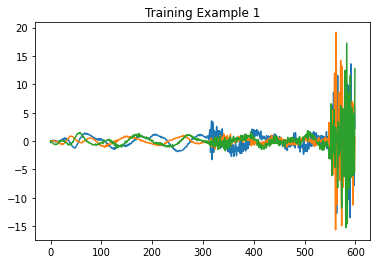

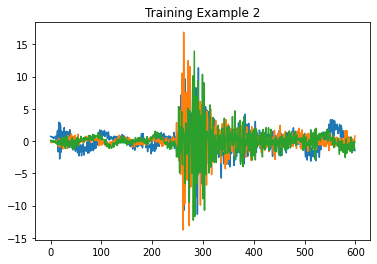

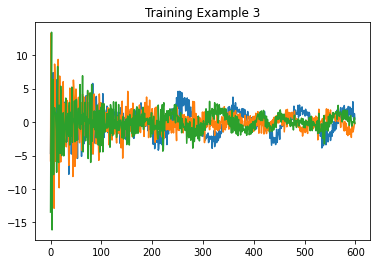

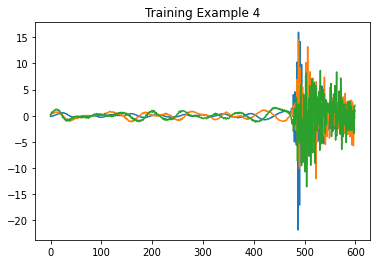

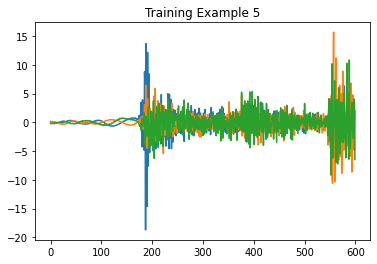

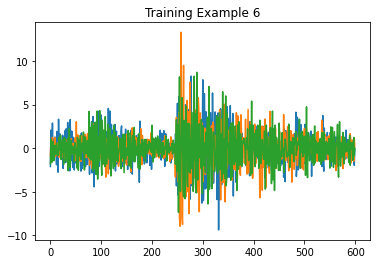

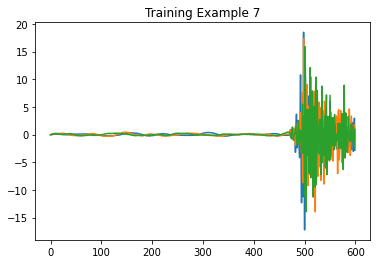

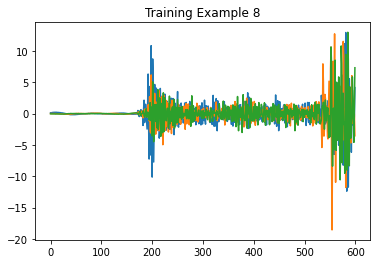

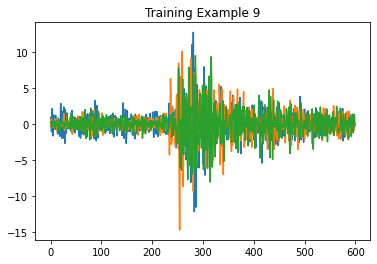

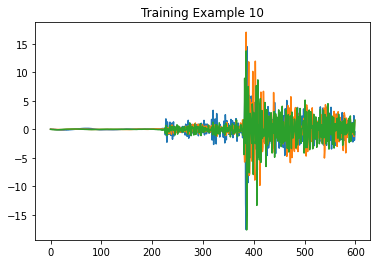

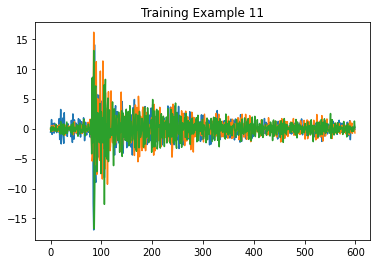

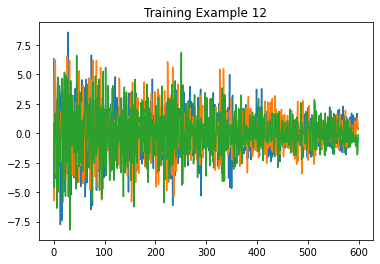

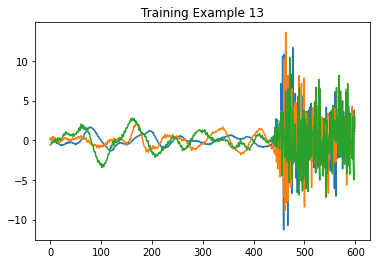

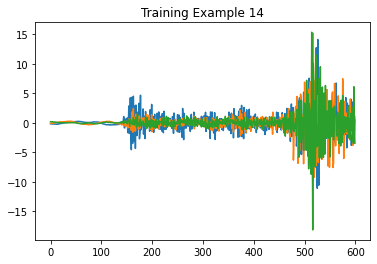

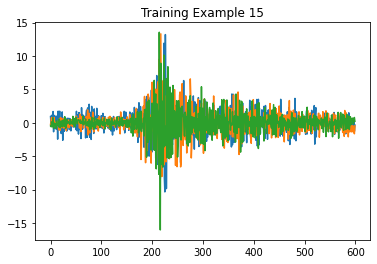

In [9]:
for i, window in enumerate(train_data['X']):
    plt.title(f'Training Example {i+1}')
    plt.plot(window.T)
    plt.show()

### Example usage of SupervisedLabel interface
---
*Currently under development and may be removed or refactored*.

* Idea was to integrate standard classification labelling functionality within our API.
* This would also allow for checking of common errors in labelling procedure

Checks are performed in the ```SupervisedLabel``` parent class (don't use ABC in this case as it then results in a lot of setup to essentially assign a single label attribute y. Which would otherwise be one line of code). Supervised labels can be either *multi-label*, *multi-class*, or *binary*. Example implementations for multi class (so standrd ```Softmax``` format) and multi-label (typical usage would be via elementwise ```Sigmoid```) cases are below. When creating labels, users' just need to define parameters for the label values, the label-type and the label dimension (C in PyTorch docstrings syntax). The label is then passed to the parent with ```super()``` - this is when all common usage checks are performed.

In [10]:
from seisbench.generate.augmentation import SupervisedLabel
from seisbench.util.ml import gaussian_pick

In [11]:
class Softmax(SupervisedLabel):
    def __init__(self, y, label_type='multi_class', dim=1):
        super().__init__(y, label_type, dim)

class MultiLabel(SupervisedLabel):
    def __init__(self,  y, label_type='multi_label', dim=1, labels=[]):
        super().__init__(y, label_type, dim)
        self.labels = labels
    
    def visualise(self):
        if len(self.labels) != self.y.shape[self.dim]:
            raise ValueError(f"Number of provided labels and number of classes differ.")
        
        for i in range(y.shape[self.dim]):
            plt.plot(y[i,:], label=self.labels[i])
        plt.legend(fancybox=True)
        plt.show()

Seems like a lot of setup for essentially the final step in constructing a PyTorch or DL model. But, the potential benefit would be that the 2 cases above already basically encompass almost all the label procedures users' will want for their ML pipelines - could also include Binary. All they need to do is define the class dimension when instansiating their label. Example for the picking problem is found below.

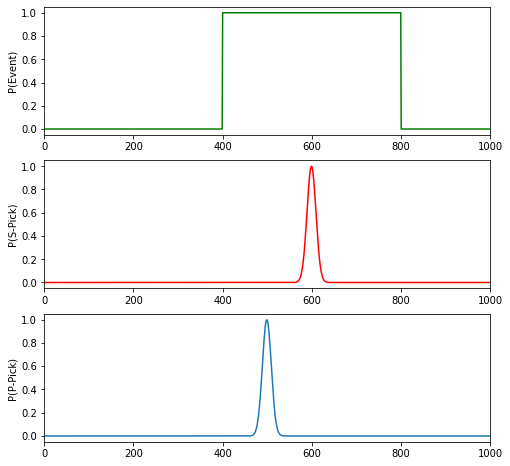

In [12]:
# Setup synethic multi-label case (e.g. data samples can belong to multiple classes such as sample being both a pick and event)
x = 1000
a = torch.Tensor(gaussian_pick(onset=500, length=x, sigma=10))
b = torch.Tensor(gaussian_pick(onset=600, length=x, sigma=10))
c = np.zeros(x)
c[400:800] = 1
c = torch.Tensor(c)

# Create label
y = torch.vstack([a, b, c])

# Visualise label
plt.figure(figsize=(8,8))
plt.subplot(313)
plt.plot(np.arange(x), a)
plt.ylabel(('P(P-Pick)'))
plt.xlim(0, x)
plt.subplot(312)
plt.plot(np.arange(x), b, 'r')
plt.ylabel(('P(S-Pick)'))
plt.xlim(0, x)
plt.subplot(311)
plt.plot(np.arange(x), c, 'g')
plt.ylabel(('P(Event)'))
plt.xlim(0, x)
plt.show()

In [13]:
y.shape # C dim is dim-0

torch.Size([3, 1000])

Pass labels to appropriate multi-label case.

In [14]:
sm = MultiLabel(y, dim=0, labels=('P', 'S', 'Event'))

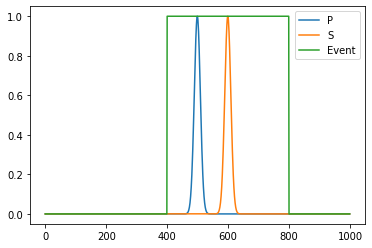

In [15]:
sm.visualise()

Try passing the same labels to an incompatible multi-class pipeline

In [16]:
# Our 'multi-class' label
sm = Softmax(y, dim=0)

ValueError: More than one label provided. For multi_class problems, only one label can be provided per input.

Could be seen as overkill/rather redundant, but this does encompass many standard supervised labelling procedures such as any type of one-hot encoding, or custom gaussian soft-assignment representations - keeping in a basic working version for now.